<a href="https://colab.research.google.com/github/Soumya-2184/Transformer_English_to_Spanish/blob/main/English_to_spanish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
class Config:
    vocab_size = 16000 # Vocabulary Size
    sequence_length = 20
    batch_size = 256
    validation_split = 0.15
    embed_dim = 256
    latent_dim = 256
    num_heads = 8
    epochs = 30 # Number of Epochs to train
    is_training = False
config = Config()

In [ ]:
import os
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

data = pd.read_csv(r"C:\Users\soumy\OneDrive\Documents\data.csv")

In [ ]:
data

,english,spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.
...,...,...
118959,There are four main causes of alcohol-related ...,Hay cuatro causas principales de muertes relac...
118960,There are mothers and fathers who will lie awa...,Hay madres y padres que se quedan despiertos d...
118961,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...
118962,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...


In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import pathlib
import random
import string
import re
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
from sklearn.model_selection import train_test_split
print(f"Tensorflow Version:{tf.__version__}")

Tensorflow Version:2.10.0


In [ ]:
data["spanish"] = data["spanish"].apply(lambda item: "[start] " + item + " [end]")

In [ ]:
data.head()

,english,spanish
0,Go.,[start] Ve. [end]
1,Go.,[start] Vete. [end]
2,Go.,[start] Vaya. [end]
3,Go.,[start] Váyase. [end]
4,Hi.,[start] Hola. [end]


In [ ]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "").replace("]", "")
print(strip_chars)
def spanish_standardize(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]"%re.escape(strip_chars), "")
english_vectorization = TextVectorization(
    max_tokens=config.vocab_size,
    output_mode="int",
    output_sequence_length=config.sequence_length,
)
spanish_vectorization = TextVectorization(
    max_tokens=config.vocab_size,
    output_mode="int",
    output_sequence_length=config.sequence_length + 1,
    standardize=spanish_standardize,
)
english_vectorization.adapt(list(data["english"]))
spanish_vectorization.adapt(list(data["spanish"]))

!"#$%&'()*+,-./:;<=>?@\^_`{|}~¿


In [ ]:
def preprocess(english, spanish):
    english = english_vectorization(english)
    spanish = spanish_vectorization(spanish)
    return ({"encoder_inputs": english, "decoder_inputs": spanish[:, :-1]}, spanish[:, 1:])
def make_dataset(df, batch_size, mode):
    dataset = tf.data.Dataset.from_tensor_slices((list(df["english"]), list(df["spanish"])))
    if mode == "train":
       dataset = dataset.shuffle(batch_size * 4)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(preprocess)
    dataset = dataset.prefetch(tf.data.AUTOTUNE).cache()
    return dataset

In [ ]:
train, valid = train_test_split(data, test_size=config.validation_split, random_state=42)
train.shape, valid.shape

((101119, 2), (17845, 2))

In [ ]:
train_ds = make_dataset(train, batch_size=config.batch_size, mode="train")
valid_ds = make_dataset(valid, batch_size=config.batch_size, mode="valid")

In [ ]:
for batch in train_ds.take(1):
    print(batch)

({'encoder_inputs': <tf.Tensor: shape=(256, 20), dtype=int64, numpy=
array([[   9,  720,   10, ...,    0,    0,    0],
       [   6, 1221,  264, ...,    0,    0,    0],
       [  45,   33,   51, ...,    0,    0,    0],
       ...,
       [   3,  129,   13, ...,    0,    0,    0],
       [  78,  160,  179, ...,    0,    0,    0],
       [  46,   14,    7, ...,    0,    0,    0]], dtype=int64)>, 'decoder_inputs': <tf.Tensor: shape=(256, 20), dtype=int64, numpy=
array([[   2,   20, 2952, ...,    0,    0,    0],
       [   2,    8, 4894, ...,    0,    0,    0],
       [   2,    7,   12, ...,    0,    0,    0],
       ...,
       [   2,  171,    5, ...,    0,    0,    0],
       [   2, 4935,    4, ...,    0,    0,    0],
       [   2,  104,   18, ...,    0,    0,    0]], dtype=int64)>}, <tf.Tensor: shape=(256, 20), dtype=int64, numpy=
array([[  20, 2952,  144, ...,    0,    0,    0],
       [   8, 4894,   10, ...,    0,    0,    0],
       [   7,   12,   63, ...,    0,    0,    0],
       .

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            mask_zero=True
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length,
            output_dim=embed_dim,
            mask_zero=True
        )

        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        embedded_tokens = self.token_embeddings(inputs)
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = self.token_embeddings.compute_mask(inputs)
        return mask


In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential([
            layers.Dense(latent_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask = None):
        causal_mask = self.get_causal_attention_mask(inputs)
        padding_mask = None
        if mask != None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask
        )

        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask
        )

        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        out = self.layernorm_3(out_2 + proj_output)

        return out

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

Shape of encoder_inputs: (None, 20)
Shape of positional_encoder_inputs: (None, 20, 256)
Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 positional_embedding (Position  (None, 20, 256)     4101120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  


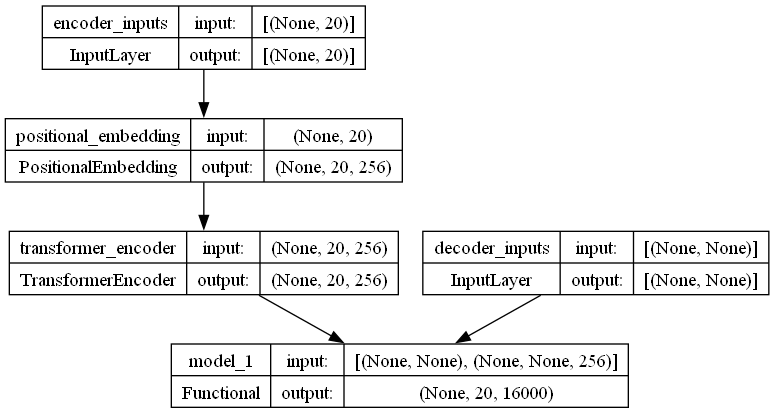

In [ ]:
def edit_distance(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.argmax(y_pred, axis=-1, output_type=y_true.dtype)
    y_true_tensor =  tf.sparse.from_dense(
        y_true
    )
    y_pred_tensor = tf.sparse.from_dense(
        y_pred
    )
    metric = 1 - tf.edit_distance(y_true_tensor, y_pred_tensor, normalize=True)
    return metric

def get_transformer(config):
    encoder_inputs = tf.keras.Input(shape=(config.sequence_length, ), name="encoder_inputs")
    print("Shape of encoder_inputs:", encoder_inputs.shape)

    x = PositionalEmbedding(config.sequence_length, config.vocab_size, config.embed_dim)(encoder_inputs)
    print("Shape of positional_encoder_inputs:", x.shape)
    encoder_outputs = TransformerEncoder(config.embed_dim, config.num_heads, config.latent_dim)(x)
    encoder = keras.Model(encoder_inputs, encoder_outputs)

    decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(shape=(None, config.embed_dim), name="decoder_state_inputs")
    x = PositionalEmbedding(config.sequence_length, config.vocab_size, config.embed_dim)(decoder_inputs)
    x = TransformerDecoder(config.embed_dim, config.latent_dim, config.num_heads)(x, encoded_seq_inputs)
    x = layers.Dropout(0.5)(x)
    decoder_outputs = layers.Dense(config.vocab_size, activation="softmax")(x)
    decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    transformer = keras.Model(
        [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
    )
    '''transformer.compile(
        "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy", edit_distance]
    )'''
    transformer.compile(
        "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return transformer
transformer = get_transformer(config)
transformer.summary()
keras.utils.plot_model(transformer, show_shapes=True)

In [ ]:
transformer.fit(train_ds, epochs=config.epochs, validation_data=valid_ds)


Epoch 1/30
395/395 [==============================] - 58s 129ms/step - loss: 1.5273 - accuracy: 0.4417 - val_loss: 1.0054 - val_accuracy: 0.5827
Epoch 2/30
395/395 [==============================] - 51s 129ms/step - loss: 0.8892 - accuracy: 0.6187 - val_loss: 0.7495 - val_accuracy: 0.6672
Epoch 3/30
395/395 [==============================] - 51s 130ms/step - loss: 0.6758 - accuracy: 0.6814 - val_loss: 0.6664 - val_accuracy: 0.6927
Epoch 4/30
395/395 [==============================] - 52s 131ms/step - loss: 0.5587 - accuracy: 0.7170 - val_loss: 0.6276 - val_accuracy: 0.7065
Epoch 5/30
395/395 [==============================] - 52s 131ms/step - loss: 0.4831 - accuracy: 0.7420 - val_loss: 0.6081 - val_accuracy: 0.7141
Epoch 6/30
395/395 [==============================] - 52s 132ms/step - loss: 0.4308 - accuracy: 0.7611 - val_loss: 0.6085 - val_accuracy: 0.7178
Epoch 7/30
395/395 [==============================] - 53s 134ms/step - loss: 0.3917 - accuracy: 0.7768 - val_loss: 0.6066 - val_ac

In [ ]:
transformer.evaluate(valid_ds)

70/70 [==============================] - 4s 59ms/step - loss: 0.7700 - accuracy: 0.7290


[0.7700448632240295, 0.7290061712265015]

In [ ]:
spanish_vocab = spanish_vectorization.get_vocabulary()
spanish_index_lookup = dict(zip(range(len(spanish_vocab)), spanish_vocab))
def remove_start_and_end_token(sentence):
    return sentence.replace("[start] ", "").replace(" [end]", "")
def decode_sequence(transformer, input_sentence):
    tokenized_input_sentence = english_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(config.sequence_length):
        tokenized_target_sentence = spanish_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spanish_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return remove_start_and_end_token(decoded_sentence)

In [ ]:
reference_sentences =[]
decoded_sentences = []  # list of decoded Spanish sentences
for i in np.random.choice(len(data), 100):
    item = data.iloc[i]
    translated = decode_sequence(transformer, item["english"])
    print("English:", remove_start_and_end_token(item["english"]))
    print("Spanish:", remove_start_and_end_token(item["spanish"]))
    print("Translated:", translated)
    reference_sentences.append(remove_start_and_end_token(item["spanish"]))
    decoded_sentences.append(translated)

English: I bought all of these televisions.
Spanish: Compré todos esos televisores.
Translated: compré toda éstos de estos cálculos
English: Sorry, I don't follow.
Spanish: Perdón, pero no entiendo.
Translated: perdón no sigamos
English: That could've been prevented.
Spanish: Eso pudo haber sido prevenido.
Translated: eso podría haber sido prevenido
English: The explorers discovered a skeleton in the cave.
Spanish: Los exploradores descubrieron un esqueleto en la cueva.
Translated: los exploradores descubrieron un esqueleto en la cueva
English: She left the baby crying.
Spanish: Ella dejó al bebé llorando.
Translated: ella dejó al bebé llorando
English: Which one do you want?
Spanish: ¿Cuál quieres?
Translated: cuál quieres
English: Tom doesn't like to travel.
Spanish: A Tom no le gusta viajar.
Translated: a tom no le gusta viajar
English: Do you know the girl standing by the window?
Spanish: ¿Conoces a la niña que está parada junto a la ventana?
Translated: conoces a la chica que está

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
corpus_score = corpus_bleu([[ref] for ref in reference_sentences], decoded_sentences)
print(f"Corpus BLEU score: {corpus_score*100:.2f}")

Corpus BLEU score: 75.36
